In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations, h for horizon, n is the size of observations used
    # e.g. compute five-step cumulative returns for the first data in S_T need the T_0-(n+4) observation 
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [3]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

hist = msft.history(start = '2022-12-30',end = '2024-02-15')

data_close_price = hist.drop(columns=["Open","High","Low","Volume","Dividends","Stock Splits"])

for i in range(5):
   data_close_price["ret"+str(i+1)] = compute_return(data_close_price["Close"].values, h=i+1)


In [4]:
data_cumret = data_close_price.drop(columns=["Close"]).dropna()

In [5]:
#prepare rolling window samples before 2024
data_train_list = []
due1_data_points = 221
for i in range (7):
    due_data = data_cumret.iloc[:due1_data_points].copy()
    data_train_list.append(due_data)
    due1_data_points +=5
    
print(len(data_train_list))


7


In [6]:
for i in range(len(data_train_list)):
    # Convert the index to datetime format
    data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/672054319.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data_train_list[i].index = pd.DatetimeIndex(data_train_list[i].index).to_period('D')


In [7]:
due1_data_train = data_train_list[0]

In [8]:
import statsmodels.api as sm

arma_mod_ret5= sm.tsa.ARIMA(due1_data_train["ret5"], order=(2,0,0))
arma_res_ret5 = arma_mod_ret5.fit()
print(arma_res_ret5.summary())

                               SARIMAX Results                                
Dep. Variable:                   ret5   No. Observations:                  221
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -339.268
Date:                Tue, 02 Apr 2024   AIC                            686.536
Time:                        21:39:16   BIC                            700.129
Sample:                    01-06-2023   HQIC                           692.025
                         - 11-15-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2840      0.304      0.934      0.350      -0.312       0.880
ar.L1          0.8895      0.062     14.302      0.000       0.768       1.011
ar.L2         -0.1230      0.055     -2.255      0.0

In [9]:
#1 submission round 

In [10]:
due1_ret5 = due1_data_train["ret5"]

due1_lag1_ret5 = due1_ret5[:-1]
due1_lag2_ret5 = due1_ret5[:-2]

due1_ret5_ar2_df = pd.concat([due1_ret5,due1_lag1_ret5,due1_lag2_ret5], axis=1)

due1_ret5_ar2_df.columns = ['ret5', 'ret5_lag1','ret5_lag2']
due1_ret5_ar2_df = due1_ret5_ar2_df.iloc[::-1]

due1_ret5_ar2_df['ret5_lag1']=due1_ret5_ar2_df['ret5_lag1'].shift(-1)
due1_ret5_ar2_df['ret5_lag2']=due1_ret5_ar2_df['ret5_lag2'].shift(-2)

#Fit quantile regresion model 
import statsmodels.formula.api as smf
tau = [.025, .25, .5, .75, .975]
estimated_values = []

due_date= due1_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due1_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))


due1_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due1_estimated_values_df) 


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-11-15  0.839145  1.910696  2.438119  2.833741  5.157442


In [11]:
#2 submission round 

In [12]:
due2_data_train = data_train_list[1]

due2_ret5 = due2_data_train["ret5"]

due2_lag1_ret5 = due2_ret5[:-1]
due2_lag2_ret5 = due2_ret5[:-2]

due2_ret5_ar2_df = pd.concat([due2_ret5, due2_lag1_ret5, due2_lag2_ret5], axis=1)

due2_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due2_ret5_ar2_df = due2_ret5_ar2_df.iloc[::-1]

due2_ret5_ar2_df['ret5_lag1'] = due2_ret5_ar2_df['ret5_lag1'].shift(-1)
due2_ret5_ar2_df['ret5_lag2'] = due2_ret5_ar2_df['ret5_lag2'].shift(-2)

# Fit quantile regression model
estimated_values = []

due_date = due2_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due2_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due2_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due2_estimated_values_df)

               0.025     0.250    0.500     0.750     0.975
Date                                                       
2023-11-22 -1.282293  0.516283  1.40468  1.701709  3.070717


In [13]:
#3 submission round 

In [14]:
due3_data_train = data_train_list[2]

due3_ret5 = due3_data_train["ret5"]

due3_lag1_ret5 = due3_ret5[:-1]
due3_lag2_ret5 = due3_ret5[:-2]

due3_ret5_ar2_df = pd.concat([due3_ret5, due3_lag1_ret5, due3_lag2_ret5], axis=1)

due3_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due3_ret5_ar2_df = due3_ret5_ar2_df.iloc[::-1]

due3_ret5_ar2_df['ret5_lag1'] = due3_ret5_ar2_df['ret5_lag1'].shift(-1)
due3_ret5_ar2_df['ret5_lag2'] = due3_ret5_ar2_df['ret5_lag2'].shift(-2)

# Fit quantile regression model
estimated_values = []

due_date = due3_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due3_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due3_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due3_estimated_values_df)

               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-11-29 -1.735772 -0.034008  0.512053  0.964626  3.083005


In [15]:
#4 submission round 

In [16]:
due4_data_train = data_train_list[3]

due4_ret5 = due4_data_train["ret5"]

due4_lag1_ret5 = due4_ret5[:-1]
due4_lag2_ret5 = due4_ret5[:-2]

due4_ret5_ar2_df = pd.concat([due4_ret5, due4_lag1_ret5, due4_lag2_ret5], axis=1)

due4_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due4_ret5_ar2_df = due4_ret5_ar2_df.iloc[::-1]

due4_ret5_ar2_df['ret5_lag1'] = due4_ret5_ar2_df['ret5_lag1'].shift(-1)
due4_ret5_ar2_df['ret5_lag2'] = due4_ret5_ar2_df['ret5_lag2'].shift(-2)

# Fit quantile regression model
estimated_values = []

due_date = due4_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due4_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due4_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due4_estimated_values_df)


               0.025    0.250    0.500     0.750     0.975
Date                                                      
2023-12-06  0.789172  2.24487  2.68583  2.985877  4.993377


In [17]:
#5 submission round 

In [18]:
due5_data_train = data_train_list[4]

due5_ret5 = due5_data_train["ret5"]

due5_lag1_ret5 = due5_ret5[:-1]
due5_lag2_ret5 = due5_ret5[:-2]

due5_ret5_ar2_df = pd.concat([due5_ret5, due5_lag1_ret5, due5_lag2_ret5], axis=1)

due5_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due5_ret5_ar2_df = due5_ret5_ar2_df.iloc[::-1]

due5_ret5_ar2_df['ret5_lag1'] = due5_ret5_ar2_df['ret5_lag1'].shift(-1)
due5_ret5_ar2_df['ret5_lag2'] = due5_ret5_ar2_df['ret5_lag2'].shift(-2)

# Fit quantile regression model
estimated_values = []

due_date = due5_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due5_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due5_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due5_estimated_values_df)


               0.025    0.250     0.500     0.750     0.975
Date                                                       
2023-12-13 -0.960867  0.69462  1.252413  1.581482  3.250781


In [19]:
#6 submission round

In [20]:
due6_data_train = data_train_list[5]

due6_ret5 = due6_data_train["ret5"]

due6_lag1_ret5 = due6_ret5[:-1]
due6_lag2_ret5 = due6_ret5[:-2]

due6_ret5_ar2_df = pd.concat([due6_ret5, due6_lag1_ret5, due6_lag2_ret5], axis=1)

due6_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due6_ret5_ar2_df = due6_ret5_ar2_df.iloc[::-1]

due6_ret5_ar2_df['ret5_lag1'] = due6_ret5_ar2_df['ret5_lag1'].shift(-1)
due6_ret5_ar2_df['ret5_lag2'] = due6_ret5_ar2_df['ret5_lag2'].shift(-2)

# Fit quantile regression model
estimated_values = []

due_date = due6_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due6_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due6_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due6_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2023-12-20 -2.449035 -0.671395 -0.138446  0.483418  2.684745


In [21]:
#7 submission round - 2024

In [22]:
due7_data_train = data_cumret[:258]
due7_data_train
due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')

due7_ret5 = due7_data_train["ret5"]

due7_lag1_ret5 = due7_ret5[:-1]
due7_lag2_ret5 = due7_ret5[:-2]

due7_ret5_ar2_df = pd.concat([due7_ret5, due7_lag1_ret5, due7_lag2_ret5], axis=1)

due7_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due7_ret5_ar2_df = due7_ret5_ar2_df.iloc[::-1]

due7_ret5_ar2_df['ret5_lag1'] = due7_ret5_ar2_df['ret5_lag1'].shift(-1)
due7_ret5_ar2_df['ret5_lag2'] = due7_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due7_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due7_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due7_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due7_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-10 -2.654994 -0.899444 -0.328061  0.220807  2.083033


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/1307086422.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due7_data_train.index = pd.DatetimeIndex(due7_data_train.index).to_period('D')


In [23]:
#8 submission round

In [24]:
due8_data_train = data_cumret[:258+5]
due8_data_train
due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')

due8_ret5 = due8_data_train["ret5"]

due8_lag1_ret5 = due8_ret5[:-1]
due8_lag2_ret5 = due8_ret5[:-2]

due8_ret5_ar2_df = pd.concat([due8_ret5, due8_lag1_ret5, due8_lag2_ret5], axis=1)

due8_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due8_ret5_ar2_df = due8_ret5_ar2_df.iloc[::-1]

due8_ret5_ar2_df['ret5_lag1'] = due8_ret5_ar2_df['ret5_lag1'].shift(-1)
due8_ret5_ar2_df['ret5_lag2'] = due8_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due8_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due8_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due8_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due8_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-17 -2.785513 -1.065528 -0.499348  0.086813  2.017098


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/3762758879.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due8_data_train.index = pd.DatetimeIndex(due8_data_train.index).to_period('D')


In [25]:
#9 submission 

In [26]:
due9_data_train = data_cumret[:258+10]
due9_data_train
due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')

due9_ret5 = due9_data_train["ret5"]

due9_lag1_ret5 = due9_ret5[:-1]
due9_lag2_ret5 = due9_ret5[:-2]

due9_ret5_ar2_df = pd.concat([due9_ret5, due9_lag1_ret5, due9_lag2_ret5], axis=1)

due9_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due9_ret5_ar2_df = due9_ret5_ar2_df.iloc[::-1]

due9_ret5_ar2_df['ret5_lag1'] = due9_ret5_ar2_df['ret5_lag1'].shift(-1)
due9_ret5_ar2_df['ret5_lag2'] = due9_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due9_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due9_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due9_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due9_estimated_values_df)


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/3657365474.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due9_data_train.index = pd.DatetimeIndex(due9_data_train.index).to_period('D')


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-24 -1.907725 -0.236998  0.329999  0.853063  2.750523


In [27]:
#10 submission 

In [28]:
due10_data_train = data_cumret[:258+15]
due10_data_train
due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')

due10_ret5 = due10_data_train["ret5"]

due10_lag1_ret5 = due10_ret5[:-1]
due10_lag2_ret5 = due10_ret5[:-2]

due10_ret5_ar2_df = pd.concat([due10_ret5, due10_lag1_ret5, due10_lag2_ret5], axis=1)

due10_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due10_ret5_ar2_df = due10_ret5_ar2_df.iloc[::-1]

due10_ret5_ar2_df['ret5_lag1'] = due10_ret5_ar2_df['ret5_lag1'].shift(-1)
due10_ret5_ar2_df['ret5_lag2'] = due10_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due10_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due10_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due10_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due10_estimated_values_df)


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/3411710633.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due10_data_train.index = pd.DatetimeIndex(due10_data_train.index).to_period('D')


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-01-31 -0.320114  1.191736  1.696683  2.080693  4.080759


In [29]:
#11 submission 

In [30]:
due11_data_train = data_cumret[:258+20]
due11_data_train
due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')

due11_ret5 = due11_data_train["ret5"]

due11_lag1_ret5 = due11_ret5[:-1]
due11_lag2_ret5 = due11_ret5[:-2]

due11_ret5_ar2_df = pd.concat([due11_ret5, due11_lag1_ret5, due11_lag2_ret5], axis=1)

due11_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due11_ret5_ar2_df = due11_ret5_ar2_df.iloc[::-1]

due11_ret5_ar2_df['ret5_lag1'] = due11_ret5_ar2_df['ret5_lag1'].shift(-1)
due11_ret5_ar2_df['ret5_lag2'] = due11_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due11_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due11_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due11_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due11_estimated_values_df)


               0.025     0.250     0.500     0.750     0.975
Date                                                        
2024-02-07 -1.680924 -0.139376  0.342303  0.898629  3.051715


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/1498603778.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due11_data_train.index = pd.DatetimeIndex(due11_data_train.index).to_period('D')


In [31]:
#12 submission 

In [32]:
due12_data_train = data_cumret[:258+25]
due12_data_train
due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')

due12_ret5 = due12_data_train["ret5"]

due12_lag1_ret5 = due12_ret5[:-1]
due12_lag2_ret5 = due12_ret5[:-2]

due12_ret5_ar2_df = pd.concat([due12_ret5, due12_lag1_ret5, due12_lag2_ret5], axis=1)

due12_ret5_ar2_df.columns = ['ret5', 'ret5_lag1', 'ret5_lag2']
due12_ret5_ar2_df = due12_ret5_ar2_df.iloc[::-1]

due12_ret5_ar2_df['ret5_lag1'] = due12_ret5_ar2_df['ret5_lag1'].shift(-1)
due12_ret5_ar2_df['ret5_lag2'] = due12_ret5_ar2_df['ret5_lag2'].shift(-2)

estimated_values = []

due_date = due12_ret5_ar2_df.head(1)
for q in tau:
    formula = f'ret5 ~ ret5_lag1 + ret5_lag2'  
    model = smf.quantreg(formula, due12_ret5_ar2_df)
    result = model.fit(q=q)
    predictions = result.predict(due_date)
    # Store the predicted values along with the quantile level
    estimated_values.append(predictions.rename(q))

due12_estimated_values_df = pd.concat(estimated_values, axis=1)

# Print the estimated quantiles for the 5-step ahead R on T_0+5
print(due12_estimated_values_df)


               0.025     0.250     0.500     0.750    0.975
Date                                                       
2024-02-14 -3.467841 -1.302106 -0.668756  0.008496  1.21304


/var/folders/dd/ghzh11c55_5czyfq85wdrrvc0000gn/T/ipykernel_48127/4282614729.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  due12_data_train.index = pd.DatetimeIndex(due12_data_train.index).to_period('D')


In [33]:
FC_results_list = [due1_estimated_values_df, due2_estimated_values_df, due3_estimated_values_df, due4_estimated_values_df,
                  due5_estimated_values_df, due6_estimated_values_df, due7_estimated_values_df, 
                  due8_estimated_values_df, due9_estimated_values_df,
                  due10_estimated_values_df, due11_estimated_values_df, due12_estimated_values_df]
FC_results_df = pd.concat(FC_results_list, axis=0)

In [34]:
# Each row of the FC_results is the quantile estimation at T0 for T0+5
FC_results_df

,0.025,0.250,0.500,0.750,0.975
Date,,,,,
2023-11-15,0.839145,1.910696,2.438119,2.833741,5.157442
2023-11-22,-1.282293,0.516283,1.404680,1.701709,3.070717
2023-11-29,-1.735772,-0.034008,0.512053,0.964626,3.083005
2023-12-06,0.789172,2.244870,2.685830,2.985877,4.993377
2023-12-13,-0.960867,0.694620,1.252413,1.581482,3.250781
2023-12-20,-2.449035,-0.671395,-0.138446,0.483418,2.684745
2024-01-10,-2.654994,-0.899444,-0.328061,0.220807,2.083033
2024-01-17,-2.785513,-1.065528,-0.499348,0.086813,2.017098
2024-01-24,-1.907725,-0.236998,0.329999,0.853063,2.750523


In [35]:
#Forcasting evaluation

relized_data = msft.history(start='2022-12-30', end='2024-02-26')
relized_data["ret5"] = compute_return(relized_data["Close"].values, h=5)

relized_data = relized_data.drop(columns=["Open", "High", "Low", "Close", "Volume", "Dividends", "Stock Splits"])
relized_data

,ret5
Date,
2022-12-30 00:00:00+01:00,NaN
2023-01-02 00:00:00+01:00,NaN
2023-01-03 00:00:00+01:00,NaN
2023-01-04 00:00:00+01:00,NaN
2023-01-05 00:00:00+01:00,NaN
...,...
2024-02-19 00:00:00+01:00,0.321775
2024-02-20 00:00:00+01:00,1.105188
2024-02-21 00:00:00+01:00,1.013634


In [36]:
dates =  ['2023-11-15', '2023-11-22', '2023-11-29', '2023-12-06', '2023-12-13', '2023-12-20',
         '2024-01-10', '2024-01-17', '2024-01-24', '2024-01-31', '2024-02-07', '2024-02-14']

# Increment each date by 7 day to obtain target Wed.
dates_5stephead = [(pd.to_datetime(date) + pd.DateOffset(days=7)).strftime('%Y-%m-%d') for date in dates]

# Select data from relized_data T0+5
realized_T05 = relized_data.loc[dates_5stephead]

In [37]:
dates_5stephead

['2023-11-22',
 '2023-11-29',
 '2023-12-06',
 '2023-12-13',
 '2023-12-20',
 '2023-12-27',
 '2024-01-17',
 '2024-01-24',
 '2024-01-31',
 '2024-02-07',
 '2024-02-14',
 '2024-02-21']

In [38]:
realized_T05.values

array([[ 1.32248477],
       [ 1.29891084],
       [ 2.98587764],
       [ 0.65591594],
       [-0.19702027],
       [ 0.54814362],
       [-1.55866322],
       [ 2.75052356],
       [ 0.08190789],
       [ 0.10761736],
       [ 0.13889171],
       [ 1.01363421]])

In [39]:
def quantile_score(q_hat, y, tau):
    scores = []
    for i in range(len(tau)):
        if q_hat[i] > y:
            score = 2 * (1 - tau[i]) * (q_hat[i] - y)
        elif y >= q_hat[i]:
            score = 2 * tau[i] * (y - q_hat[i])
        else:
            score = 0
        scores.append(score)
    return scores

ret_5_scores = []


# Iterate over each submission day (row) in FC_results

for i in range(FC_results_df.shape[0]):
    q_hat = FC_results_df.iloc[i].values
    y = realized_T05.iloc[i].values
    scores = quantile_score(q_hat, y, tau)
    ret_5_scores.append(scores)
    
ret_5_scores

[[array([0.02416701]),
  array([0.88231702]),
  array([1.11563374]),
  array([0.75562833]),
  array([0.19174788])],
 [array([0.12906017]),
  array([0.39131376]),
  array([0.10576943]),
  array([0.20139885]),
  array([0.08859029])],
 [array([0.23608247]),
  array([1.50994297]),
  array([2.47382443]),
  array([3.0318768]),
  array([0.00485635])],
 [array([0.25984902]),
  array([2.38343101]),
  array([2.02991451]),
  array([1.16498047]),
  array([0.21687306])],
 [array([0.03819236]),
  array([1.33746042]),
  array([1.44943309]),
  array([0.889251]),
  array([0.17239007])],
 [array([0.14985894]),
  array([0.60976921]),
  array([0.68658946]),
  array([0.09708839]),
  array([0.10683009])],
 [array([0.05481655]),
  array([0.98882934]),
  array([1.23060219]),
  array([0.88973515]),
  array([0.1820848])],
 [array([0.2768018]),
  array([1.90802601]),
  array([3.24987115]),
  array([3.99556637]),
  array([1.43017923])],
 [array([0.09948166]),
  array([0.15945296]),
  array([0.24809121]),
  array(

In [40]:
columns = ['due1', 'due2', 'due3', 'due4', 'due5', 'due6', 'due7', 'due8', 'due9', 'due10', 'due11', 'due12']
ret_5_scores_df = pd.DataFrame(ret_5_scores).T
ret_5_scores_df.columns = columns
ret_5_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0,[0.02416701324274111],[0.12906017232089395],[0.23608247450008424],[0.25984902434102586],[0.03819236019340173],[0.14985894250120593],[0.05481655195195814],[0.27680180285569395],[0.09948165744715606],[0.021386549602790912],[0.09099079161612408],[0.22407374410497508]
1,[0.8823170208320609],[0.39131375948041747],[1.50994297404673],[2.3834310091622024],[1.3374604205007568],[0.6097692105318424],[0.9888293443367532],[1.9080260136179374],[0.1594529614274023],[1.6261772866152437],[0.13913379321155878],[1.1578701263589108]
2,[1.1156337403211443],[0.10576942950703683],[2.473824433386],[2.029914514369872],[1.449433088438823],[0.6865894611879251],[1.2306021854019278],[3.2498711491617644],[0.24809121069827667],[1.589065398114628],[0.20341084784095564],[1.6823898364378818]
3,[0.755628331054635],[0.2013988544381572],[3.0318767972083465],[1.1649804661095786],[0.889251003705464],[0.09708838705076206],[0.8897351514653102],[3.995566371924666],[0.3855774393922591],[0.9865380233121996],[0.3798685370143506],[1.5077073014725295]
4,[0.1917478794991412],[0.08859029137497697],[0.004856346510468938],[0.2168730640758071],[0.17239006918842945],[0.10683009291851982],[0.18208480487039666],[1.430179234514814],[0.13343077064839629],[0.19865710073636406],[0.14564116859806367],[0.009970291782288941]


In [41]:

ret_5_scores_df.index = tau

In [42]:
ret_5_scores_df

,due1,due2,due3,due4,due5,due6,due7,due8,due9,due10,due11,due12
0.025,[0.02416701324274111],[0.12906017232089395],[0.23608247450008424],[0.25984902434102586],[0.03819236019340173],[0.14985894250120593],[0.05481655195195814],[0.27680180285569395],[0.09948165744715606],[0.021386549602790912],[0.09099079161612408],[0.22407374410497508]
0.250,[0.8823170208320609],[0.39131375948041747],[1.50994297404673],[2.3834310091622024],[1.3374604205007568],[0.6097692105318424],[0.9888293443367532],[1.9080260136179374],[0.1594529614274023],[1.6261772866152437],[0.13913379321155878],[1.1578701263589108]
0.500,[1.1156337403211443],[0.10576942950703683],[2.473824433386],[2.029914514369872],[1.449433088438823],[0.6865894611879251],[1.2306021854019278],[3.2498711491617644],[0.24809121069827667],[1.589065398114628],[0.20341084784095564],[1.6823898364378818]
0.750,[0.755628331054635],[0.2013988544381572],[3.0318767972083465],[1.1649804661095786],[0.889251003705464],[0.09708838705076206],[0.8897351514653102],[3.995566371924666],[0.3855774393922591],[0.9865380233121996],[0.3798685370143506],[1.5077073014725295]
0.975,[0.1917478794991412],[0.08859029137497697],[0.004856346510468938],[0.2168730640758071],[0.17239006918842945],[0.10683009291851982],[0.18208480487039666],[1.430179234514814],[0.13343077064839629],[0.19865710073636406],[0.14564116859806367],[0.009970291782288941]


In [43]:
ret_5_scores_df=ret_5_scores_df.astype(float)

Text(0, 0.5, 'Score')

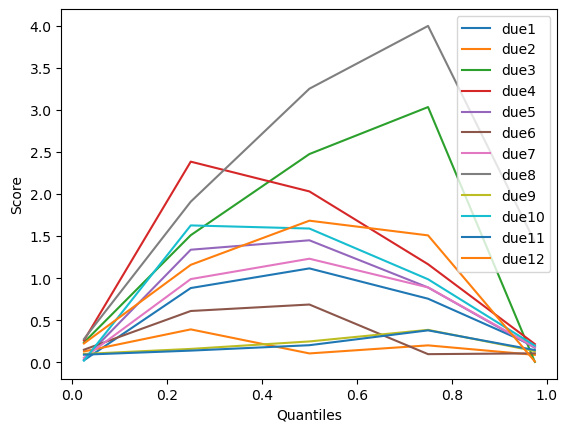

In [53]:
ret_5_scores_df.plot()
plt.xlabel('Quantiles')
plt.ylabel('Score')